In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
#import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [2]:
from keras.layers import add, ConvLSTM2D, Reshape, Dense, AveragePooling2D, Input, Conv2DTranspose, TimeDistributed, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import add, Reshape, Dense, Input, TimeDistributed, Dropout, Activation, LSTM, Conv1D, Cropping1D,GRU
from keras.layers import MaxPooling1D, UpSampling1D, Cropping1D, SpatialDropout1D, Bidirectional, BatchNormalization 
from keras.models import Model, Sequential
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.optimizers import Adam
import matplotlib

In [3]:
#时域模态信息

import scipy.io as scio
import pandas as pd

#1 input
feature1 = r'\时域1-5s\ACC_EW.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_EW']
A=AA[:,0:400]

feature2 = r'\时域1-5s\ACC_NS.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_NS']
B=BB[:,0:400]

feature3 = r'\时域1-5s\ACC_UD.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_UD']
C=CC[:,0:400]


raw_data1=np.hstack((A,B))
x_data=np.hstack((raw_data1,C))

print(x_data.shape)



(53286, 1200)


In [4]:
#频域模态信息

import scipy.io as scio
import pandas as pd

#input
feature1s = r'\频域\3s\spec_EW.mat'
data1s = scio.loadmat(feature1s)
AAs=data1s['spec_EW']
As=AAs[:,0:200]

feature2s = r'\频域\3s\spec_NS.mat'
data2s = scio.loadmat(feature2s)
BBs=data2s['spec_NS']
Bs=BBs[:,0:200]

feature3s = r'\频域\3s\spec_UD.mat'
data3s = scio.loadmat(feature3s)
CCs=data3s['spec_UD']
Cs=CCs[:,0:200]

raw_data1s=np.hstack((As,Bs))
x_datas=np.hstack((raw_data1s,Cs))

print(x_datas.shape)



(53286, 600)


In [5]:
#特征模态信息

import scipy.io as scio
import pandas as pd

label = pd.read_csv(open(r'\特征模态信息3s.csv',encoding='UTF-8'))
y_data=label.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values  #特征嵌入
print(y_data[0])
print(y_data.shape)

[0.01591836 0.06319288 1.28865615 0.00216419 1.30908207 0.00139702
 0.1574331  0.30811366 0.00250608 1.        ]
(53286, 10)


In [6]:
from sklearn.model_selection import train_test_split  #random_state=21  24  26  27  65
#时域划分
train_xxt, test_xxt, train_y1, test_y1 = train_test_split(x_data, y_data, test_size=0.2, random_state=30) 
#频域划分
train_xxs, test_xxs, train_y1, test_y1 = train_test_split(x_datas, y_data, test_size=0.2, random_state=30) 

In [7]:
train_y=train_y1[:,[9]]
train_feature=train_y1[:,[0,1,2,3,4,5,6,7,8]]
print(train_y.shape)
print(train_y[1])

print(train_feature.shape)
print(train_feature[1])


test_y=test_y1[:,[9]]
test_feature=test_y1[:,[0,1,2,3,4,5,6,7,8]]
print(test_y.shape)
print(test_y[1])

print(test_feature.shape)
print(test_feature[1])


(42628, 1)
[1.]
(42628, 9)
[7.6042600e-04 3.7566390e-03 8.8836015e-02 2.4579300e-05 1.3273381e-01
 1.1320200e-05 2.7224624e-01 2.6569918e-01 2.0702300e-04]
(10658, 1)
[2.]
(10658, 9)
[0.02253614 0.07986302 0.60228547 0.04616989 1.73744674 0.00363566
 1.52385847 0.83315002 0.03434189]


In [8]:
#时域模态 训练
train_xt=[]
for i in range(len(train_xxt)):
    train_xt.append(np.array(train_xxt[i].reshape(3,1,400)).T)

In [9]:
#时域模态 测试
test_xt=[]
for i in range(len(test_xxt)):
    test_xt.append(np.array(test_xxt[i].reshape(3,1,400)).T)

In [10]:
#频域模态 训练
train_xs=[]
for i in range(len(train_xxs)):
    train_xs.append(np.array(train_xxs[i].reshape(3,1,200)).T)


In [11]:
#频域模态 测试
test_xs=[]
for i in range(len(test_xxs)):
    test_xs.append(np.array(test_xxs[i].reshape(3,1,200)).T)

In [12]:
train_xt=np.array(train_xt)
test_xt=np.array(test_xt)

train_xs=np.array(train_xs)
test_xs=np.array(test_xs)

In [13]:
#3#  ##Reshaping
#时域
train_xt = np.reshape(train_xt, (train_xt.shape[0], 400, 3))
test_xt = np.reshape(test_xt, (test_xt.shape[0], 400, 3))
print("0",train_xt.shape[0])
print("1",train_xt.shape[1])
print(train_xt.shape)


#频域
train_xs = np.reshape(train_xs, (train_xs.shape[0], 200, 3))
test_xs = np.reshape(test_xs, (test_xs.shape[0], 200, 3))
print("0",train_xs.shape[0])
print("1",train_xs.shape[1])
print(train_xs.shape)



0 42628
1 400
(42628, 400, 3)
0 42628
1 200
(42628, 200, 3)


In [14]:
seed=50
def Timedomain(x):
    
    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,

    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,
    
    
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458
    

    x = tf.keras.layers.Bidirectional(GRU(128,use_bias=True, return_sequences = True,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)    
    
    x = tf.keras.layers.Bidirectional(GRU(64,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458    
    
    return x

def Specdomain(x):
    
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    
    
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458

    x = tf.keras.layers.Bidirectional(GRU(64,use_bias=True, return_sequences = True,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    

    x = tf.keras.layers.Bidirectional(GRU(32,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458     
    
    
    return x

In [15]:
seed=50
drop_rate = 0.2
from tensorflow import keras
from keras.models import Model
def CRmodel():
    inpt1 = Input(shape=(400, 3), name='input_layer1') #时域
    
    x1 = Timedomain(inpt1)
    

    e = Dense(64, activation='relu')(x1)#relu
    e = Dense(32, activation='relu')(e)
    e = Dense(3)(e)
    oupts = Activation('softmax', name='output_layer')(e)

#    
    model=Model(inputs=[inpt1], outputs=oupts)
    return model

In [16]:

from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers


model = CRmodel()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer1 (InputLayer)    [(None, 400, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 128)          1280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)           

In [17]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [18]:
import time
import datetime
epochs=500  # how many passes through our data


lr_reducer = ReduceLROnPlateau(monitor='val_acc',
                               factor=0.1,
                                cooldown= 0,
                                patience= 5, #patience= 5
                                min_lr=0.5e-6) #min_lr=0.5e-6

early_stopping_monitor = EarlyStopping(monitor= 'val_acc', patience = 10) #patience = 45   10
callbacks = [lr_reducer, early_stopping_monitor]

rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=rms, loss=losses.sparse_categorical_crossentropy,metrics=["acc"])

history=model.fit([train_xt], train_y, epochs = epochs,batch_size = 256,shuffle=True,\
                  validation_split=0.1,callbacks=callbacks) #epochs = 20, batch_size = 64   ,class_weight=weights


Epoch 1/500
150/150 [==============================] - 22s 145ms/step - loss: 0.2460 - acc: 0.8995 - val_loss: 0.1288 - val_acc: 0.9432
Epoch 2/500
150/150 [==============================] - 20s 134ms/step - loss: 0.1288 - acc: 0.9480 - val_loss: 0.1299 - val_acc: 0.9496
Epoch 3/500
150/150 [==============================] - 22s 144ms/step - loss: 0.1172 - acc: 0.9529 - val_loss: 0.1036 - val_acc: 0.9622
Epoch 4/500
150/150 [==============================] - 21s 140ms/step - loss: 0.1102 - acc: 0.9576 - val_loss: 0.0937 - val_acc: 0.9643
Epoch 5/500
150/150 [==============================] - 21s 137ms/step - loss: 0.1074 - acc: 0.9573 - val_loss: 0.1038 - val_acc: 0.9613
Epoch 6/500
150/150 [==============================] - 21s 142ms/step - loss: 0.1025 - acc: 0.9605 - val_loss: 0.1048 - val_acc: 0.9587
Epoch 7/500
150/150 [==============================] - 21s 142ms/step - loss: 0.0992 - acc: 0.9604 - val_loss: 0.0939 - val_acc: 0.9641
Epoch 8/500
150/150 [===========================

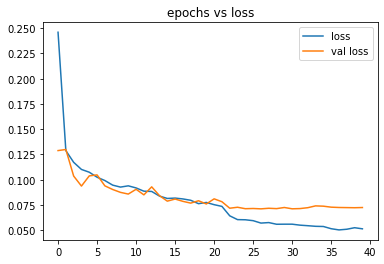

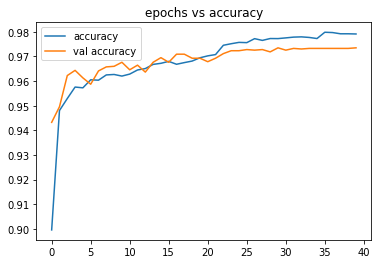

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

In [20]:
results_test = model.evaluate([test_xt], test_y)
results_train = model.evaluate([train_xt], train_y)
print(results_test)
print(results_train)

1333/1333 [==============================] - 16s 12ms/step - loss: 0.0452 - acc: 0.9827
[0.08491750061511993, 0.9681929349899292]
[0.045216817408800125, 0.9826639890670776]


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.rcParams['font.sans-serif']=['times new roman'] #显示中文标签
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title,fontproperties='Times New Roman', size=12)
    cb=plt.colorbar()
    cb.set_label(label='Number of records',fontproperties='Times New Roman',size=10)
    cb.ax.tick_params(labelsize=10)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0,fontproperties='Times New Roman', size=10)
    plt.yticks(tick_marks, classes,fontproperties='Times New Roman', size=10)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],fontproperties='Times New Roman', size=10,
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label',fontproperties='Times New Roman', fontsize=10)
    plt.xlabel('Predicted label', fontproperties='Times New Roman',fontsize=10)

(42628, 3)
(42628,)
             precision    recall  f1-score   support

        0.0     0.9996    0.9989    0.9993     20803
        1.0     0.9741    0.9812    0.9777     16232
        2.0     0.9441    0.9263    0.9351      5593

avg / total     0.9826    0.9827    0.9826     42628



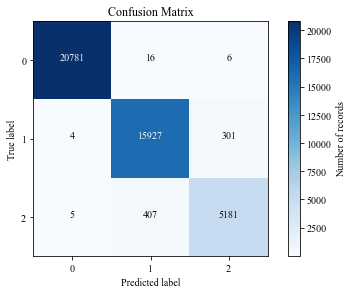

In [22]:
#Train result
predictions_train = model.predict([train_xt])
print(predictions_train.shape)
train_pre = np.argmax(predictions_train,axis = 1)
print(train_pre.shape)

#训练结果
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt   
import itertools
from sklearn.metrics import accuracy_score
cm=sklearn.metrics.confusion_matrix(train_y, train_pre)

plot_confusion_matrix(cm,classes=['0','1','2'],title='Confusion Matrix')


from sklearn.metrics import classification_report
print(classification_report(train_y, train_pre,digits=4))



(10658, 3)
(10658,)
             precision    recall  f1-score   support

        0.0    0.99847   0.99923   0.99885      5210
        1.0    0.95746   0.96007   0.95876      4032
        2.0    0.88651   0.87712   0.88179      1416

avg / total    0.96808   0.96819   0.96813     10658

accuracy: 0.9681929067367235


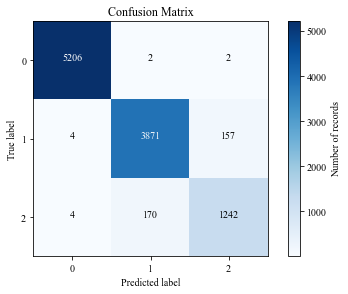

In [23]:
#Test result
predictions_test = model.predict([test_xt])
print(predictions_test.shape)
test_pre = np.argmax(predictions_test,axis = 1)
print(test_pre.shape)

#测试结果
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt   
import itertools
from sklearn.metrics import accuracy_score
cm=sklearn.metrics.confusion_matrix(test_y, test_pre)

plot_confusion_matrix(cm,classes=['0','1','2'],title='Confusion Matrix')


from sklearn.metrics import classification_report
print(classification_report(test_y, test_pre,digits=5))
from sklearn.metrics import accuracy_score
print("accuracy:",accuracy_score(test_y, test_pre))

In [24]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
# 将标签二值化
y_test_bin = label_binarize(test_y, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

#test_pre_bin=label_binarize(test_pre, classes=[0, 1, 2]) ###

In [25]:
from sklearn.metrics import roc_curve, auc
# 计算每一类的ROC
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

C:\Users\zhujingbao\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


In [27]:
## Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

<Figure size 432x288 with 0 Axes>

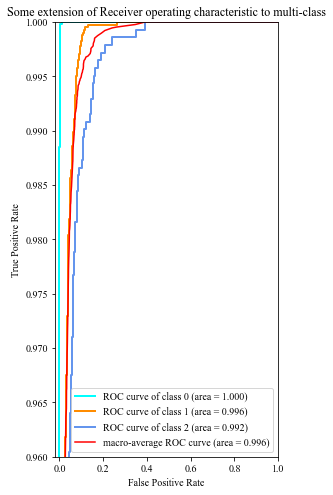

In [28]:
# Plot all ROC curves
lw=2
plt.figure()
fig = plt.figure(figsize=(4, 8)) #调用figure创建一个绘图对象
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))
    
    

    
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='red')


#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
#plt.ylim([0.0, 1.02])
plt.ylim([0.96, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
#保存噪声的ROC曲线
fpr_noise=fpr[0]
fpr_noise=fpr_noise.reshape(fpr_noise.shape[0],1)
tpr_noise=tpr[0]
tpr_noise=tpr_noise.reshape(tpr_noise.shape[0],1)
threshold_noise=np.round(thresholds[0], decimals=9)
threshold_noise=threshold_noise.reshape(threshold_noise.shape[0],1)


roc_noise=np.concatenate((fpr_noise,tpr_noise,threshold_noise),axis=1)

data_noise = pd.DataFrame(roc_noise) #将数组转换为dataframe结构
data_noise.columns=['fpr','tpr','threshold']
writer_noise = pd.ExcelWriter(r'\时域数据\ROC_noise.xls')   # 写入Excel文件

data_noise.to_excel(writer_noise,float_format='%.9f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_noise.save()
writer_noise.close()


In [30]:
#保存小震的ROC曲线
fpr_xz=fpr[1]
fpr_xz=fpr_xz.reshape(fpr_xz.shape[0],1)
tpr_xz=tpr[1]
tpr_xz=tpr_xz.reshape(tpr_xz.shape[0],1)
threshold_xz=np.round(thresholds[1], decimals=9)
threshold_xz=threshold_xz.reshape(threshold_xz.shape[0],1)
roc_xz=np.concatenate((fpr_xz,tpr_xz,threshold_xz),axis=1)

data_xz = pd.DataFrame(roc_xz) #将数组转换为dataframe结构
data_xz.columns=['fpr','tpr','threshold']
writer_xz = pd.ExcelWriter(r'\时域数据\ROC_小震.xls')   # 写入Excel文件

data_xz.to_excel(writer_xz,float_format='%.9f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_xz.save()
writer_xz.close()

In [31]:
#保存大震的ROC曲线
fpr_dz=fpr[2]
fpr_dz=fpr_dz.reshape(fpr_dz.shape[0],1)
tpr_dz=tpr[2]
tpr_dz=tpr_dz.reshape(tpr_dz.shape[0],1)
threshold_dz=np.round(thresholds[2], decimals=9)
threshold_dz=threshold_dz.reshape(threshold_dz.shape[0],1)
roc_dz=np.concatenate((fpr_dz,tpr_dz,threshold_dz),axis=1)

data_dz = pd.DataFrame(roc_dz) #将数组转换为dataframe结构
data_dz.columns=['fpr','tpr','threshold']
writer_dz = pd.ExcelWriter(r'\时域数据\ROC_大震.xls')   # 写入Excel文件

data_dz.to_excel(writer_dz,float_format='%.9f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_dz.save()
writer_dz.close()

In [32]:
#保存Marco的ROC曲线
fpr_Marco=fpr["macro"]
fpr_Marco=fpr_Marco.reshape(fpr_Marco.shape[0],1)
tpr_Marco=tpr["macro"]
tpr_Marco=tpr_Marco.reshape(tpr_Marco.shape[0],1)

roc_Marco=np.concatenate((fpr_Marco,tpr_Marco),axis=1)

data_Marco = pd.DataFrame(roc_Marco) #将数组转换为dataframe结构
data_Marco.columns=['fpr','tpr']
writer_Marco = pd.ExcelWriter(r'\时域数据\ROC_Marco.xls')   # 写入Excel文件

data_Marco.to_excel(writer_Marco,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_Marco.save()
writer_Marco.close()

